# 0.特微量

usd_pledged: 誓約された列の米ドルでの換算 (conversion done by kickstarter)

usd pledge real: 誓約された列の米ドルでの変換（Fixer.io APIからの変換）

usd goal real:目標列の米ドルでの変換（Fixer.io APIからの変換）

# 1.使用ライブラリimport

In [4]:
# Basic Library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# sklearn utility
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss,f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics   
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

## sklearn ensembles 
from sklearn.linear_model import SGDClassifier

# 2.データ読み込み

In [5]:
df = pd.read_csv("/kaggle/input/kickstarter-projects/ks-projects-201801.csv")
# 余分なカラム削除（説明変数として使えないもの）
df = df.drop(['ID',"name"], axis=1)
df.head()

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# 3.EDA(探索的データ解析)

## 3.1 統計量確認（簡易）

In [6]:
# レコード数
len(df)

378661

In [7]:
# カラム情報
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   category          378661 non-null  object 
 1   main_category     378661 non-null  object 
 2   currency          378661 non-null  object 
 3   deadline          378661 non-null  object 
 4   goal              378661 non-null  float64
 5   launched          378661 non-null  object 
 6   pledged           378661 non-null  float64
 7   state             378661 non-null  object 
 8   backers           378661 non-null  int64  
 9   country           378661 non-null  object 
 10  usd pledged       374864 non-null  float64
 11  usd_pledged_real  378661 non-null  float64
 12  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(1), object(7)
memory usage: 37.6+ MB


In [8]:
# 数列
num_cols = ['goal', 'pledged', 'backers', "usd pledged", "usd_pledged_real","usd_goal_real"]
print("Num Cols : ", num_cols)

# カテゴリカル変数列
cat_cols = ["category","main_category","currency"]
print("Cat Cols : ", cat_cols)

Num Cols :  ['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']
Cat Cols :  ['category', 'main_category', 'currency']


In [9]:
# 統計量
df.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [10]:
# 欠損値確認
df.isnull().sum()

category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [11]:
# カラムごとのユニーク値数確認
df.nunique()

category               159
main_category           15
currency                14
deadline              3164
goal                  8353
launched            378089
pledged              62130
state                    6
backers               3963
country                 23
usd pledged          95455
usd_pledged_real    106065
usd_goal_real        50339
dtype: int64

## 3.2 データ加工

In [12]:
# 目的変数のユニーク値確認
df["state"].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [13]:
# カラムの属性ごとのカウント
df["state"].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [14]:
# 成功/失敗の結果が出ているレコードだけ抽出
df = df.loc[(df["state"] == "failed") | (df["state"] == "successful")]
df

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,Small Batch,Food,USD,2017-04-19,6500.0,2017-03-20 22:08:22,154.0,failed,4,US,0.0,154.0,6500.00
378657,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.00
378658,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.00
378659,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.00


In [15]:
# 目的変数（state）を数値化
le = LabelEncoder()
df["state"] = le.fit_transform(df["state"])
df["state"].value_counts()

0    197719
1    133956
Name: state, dtype: int64

In [16]:
# 期間カラム（開始 - 締切）を作成
df["period"] = pd.to_datetime(df.loc[:, "deadline"], format="%Y-%m-%d") - pd.to_datetime(df.loc[:, "launched"],format="%Y-%m-%d")
df["period"] = df["period"].dt.days
df["period"]

0         58
1         59
2         44
3         29
5         34
          ..
378654    29
378657    26
378658    45
378659    30
378660    27
Name: period, Length: 331675, dtype: int64

### 3.3　欠損値処理

In [17]:
df.isnull().sum()

category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
period                0
dtype: int64

In [18]:
# 欠損値
print("欠損値の平均 : {}".format(df["usd pledged"].mean()))
print("欠損値の標準偏差 : {}".format(df["usd pledged"].std()))

欠損値の平均 : 7684.569010061475
欠損値の標準偏差 : 83209.37721233808


###  successful

In [19]:
# state = successful 条件下における usd pledged の統計量（平均値・中央値・標準偏差）
success_num = df["usd pledged"].loc[(df["state"] == 1)].isnull().sum()
success_mean = df["usd pledged"].loc[(df["state"] == 1)].mean()
success_median = df["usd pledged"].loc[(df["state"] == 1)].median()
success_std = df["usd pledged"].loc[(df["state"] == 1)].std()

print("state ： 成功 ")
print("欠損値：{}".format(success_num))
print("平均値：{}".format(success_mean))
print("中央値：{}".format(success_median))
print("標準偏差：{}".format(success_std))

state ： 成功 
欠損値：105
平均値：17356.034449275667
中央値：3655.66
標準偏差：130122.8081788011


### failed

In [20]:
# state = failed 条件下における usd pledged の統計量（平均値・中央値・標準偏差）
fail_num = df["usd pledged"].loc[(df["state"] == 0)].isnull().sum()
fail_mean = df["usd pledged"].loc[(df["state"] == 0)].mean()
fail_median = df["usd pledged"].loc[(df["state"] == 0)].median()
fail_std = df["usd pledged"].loc[(df["state"] == 0)].std()

print("state ： 失敗 ")
print("欠損値：{}".format(fail_num))
print("平均値：{}".format(fail_mean))
print("中央値：{}".format(fail_median))
print("標準偏差：{}".format(fail_std))

state ： 失敗 
欠損値：105
平均値：1133.7410297347358
中央値：66.0
標準偏差：6221.653616615349


In [21]:
# 外れ値対策
# "usd pledged"がNULLのindex取得
index_NaN = list(df["usd pledged"][df["usd pledged"].isnull()].index)

for i in index_NaN:
    # 同一条件(state/main_category/currency)での 「usd pledged」 の平均値
    usd_pledged_pred = df["usd pledged"][((df['state'] == df["state"][i]) & 
                       (df['main_category'] == df["main_category"][i]) &
                       (df['currency'] == df["currency"][i]))].mean()
        
    # state 同一条件での 「usd pledged」 の平均値
    usd_pledged_avg =  df["usd pledged"][(df['state'] == df["state"][i])].mean()
    
    # 
    if not np.isnan(usd_pledged_pred):
        df["usd pledged"][i] = usd_pledged_pred
    else:
        df["usd pledged"][i] = usd_pledged_avg

In [22]:
df.isnull().sum()

category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
period              0
dtype: int64

# 4. ビジュアライゼーション

### ①数値変数

#### 相関行列

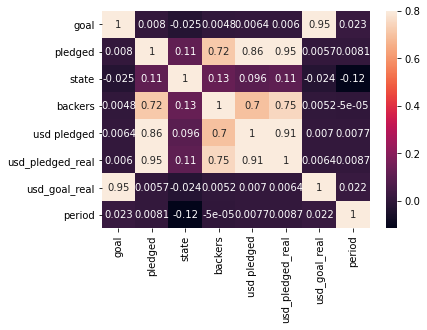

In [23]:
sns.heatmap(df.corr(), vmax=.8, annot=True);

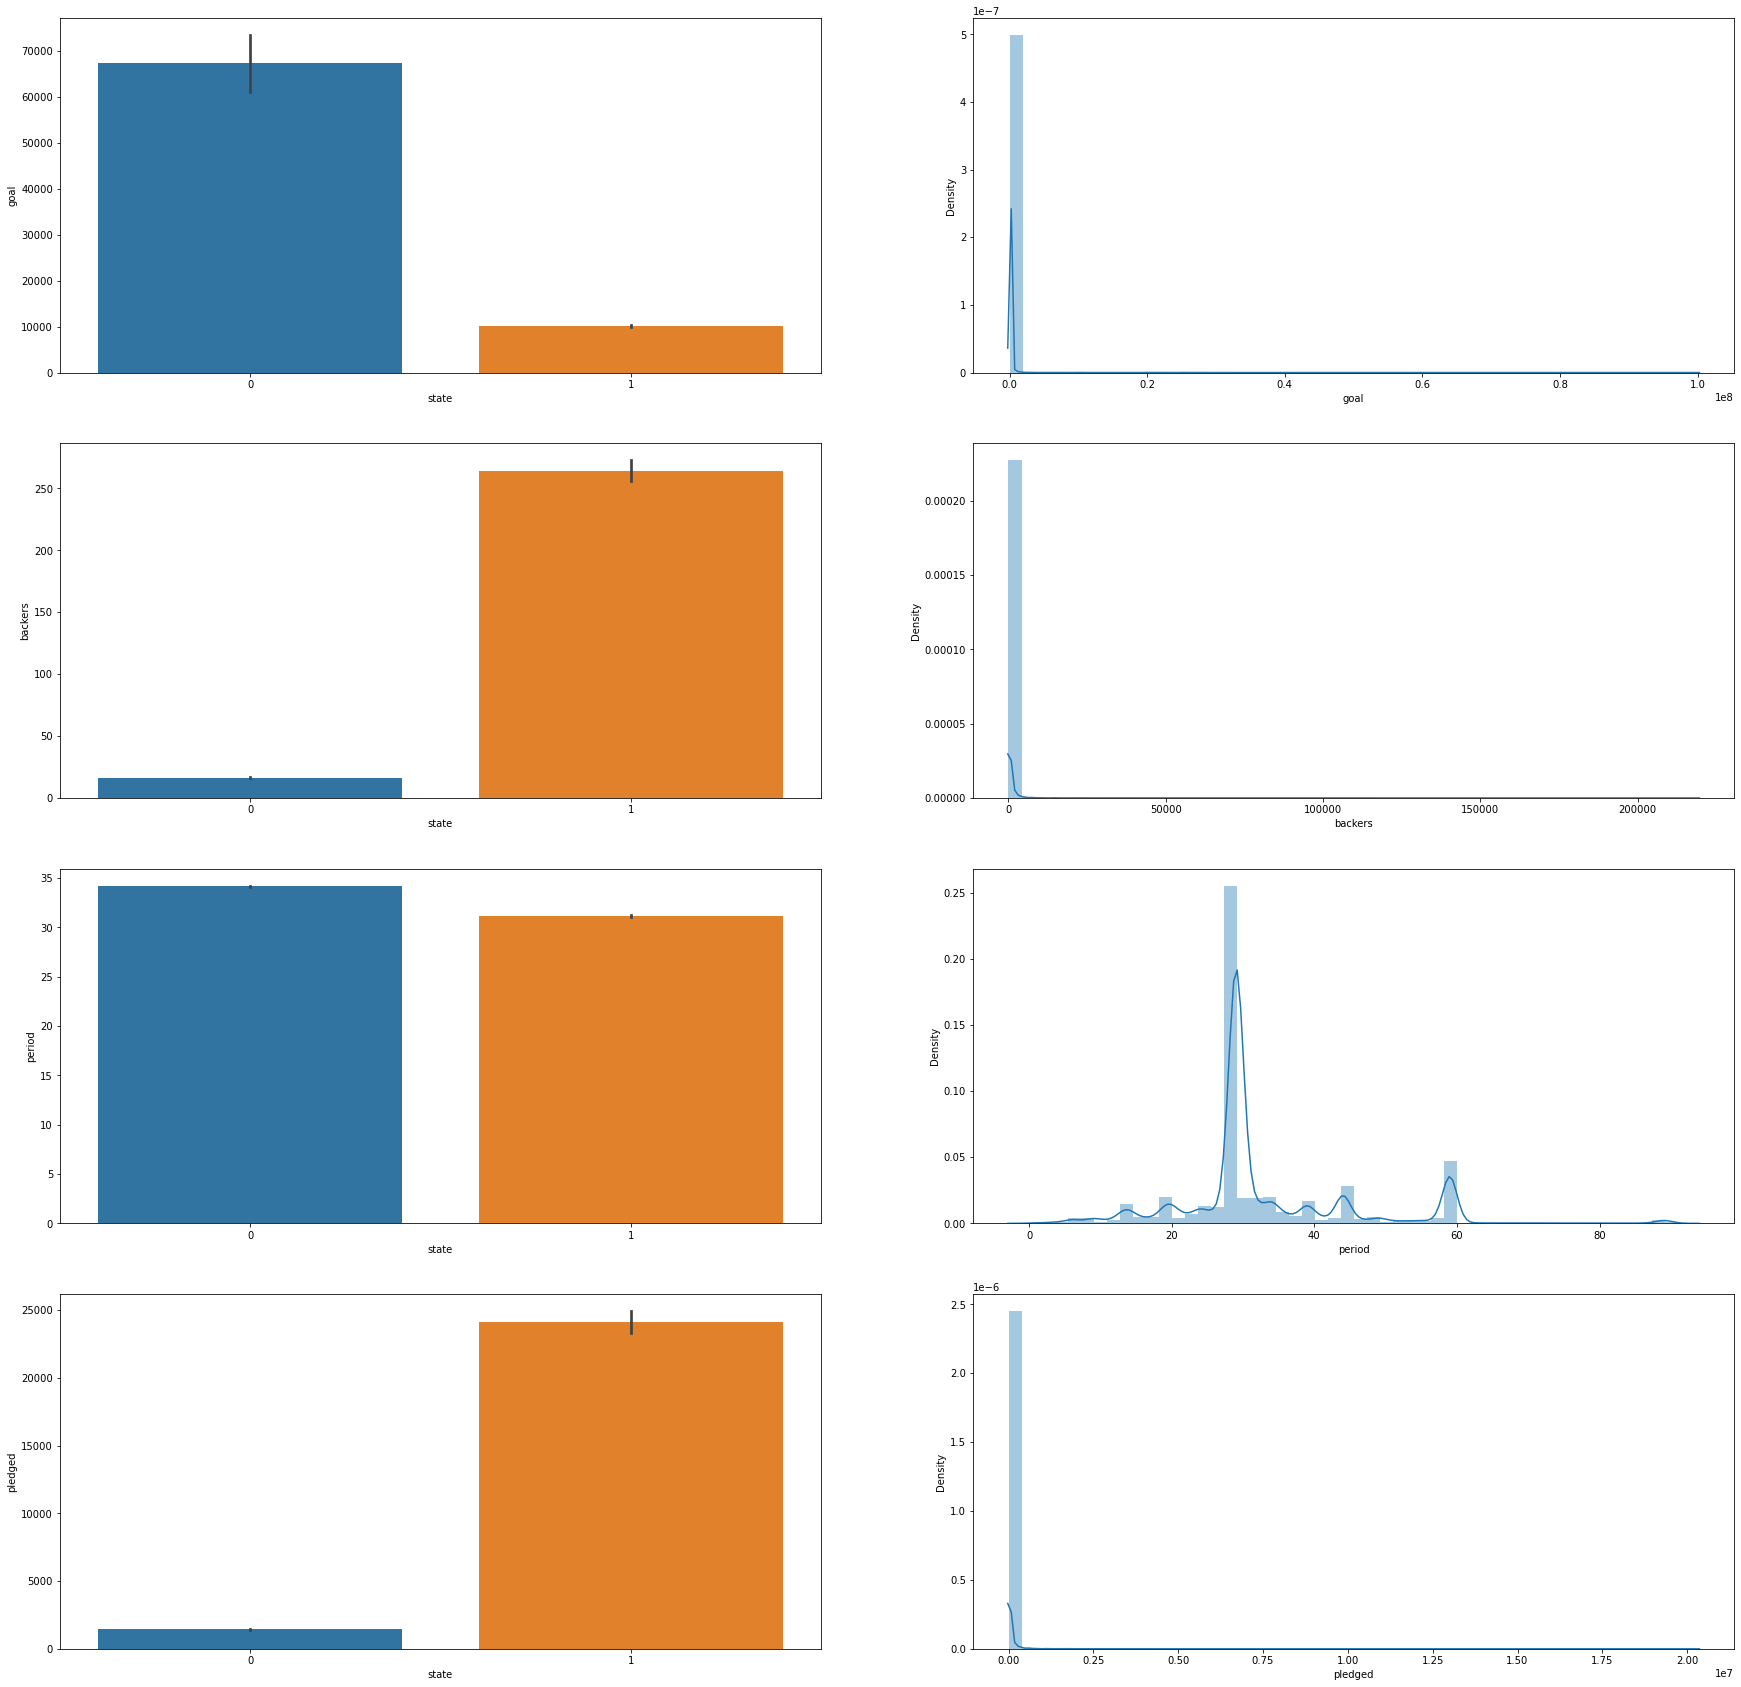

In [24]:
fig,ax=plt.subplots(4,2,figsize=(30,30))
# state / goal
sns.barplot(df.state,df.goal,ax=ax[0,0])
sns.distplot(df.goal,ax=ax[0,1])

# state / backers
sns.barplot(df.state,df.backers,ax=ax[1,0])
sns.distplot(df.backers,ax=ax[1,1])

# state / periord
sns.barplot(df.state,df.period,ax=ax[2,0])
sns.distplot(df.period,ax=ax[2,1])

# state / pledged
sns.barplot(df.state,df.pledged,ax=ax[3,0])
sns.distplot(df.pledged,ax=ax[3,1])

plt.show()

### ② カテゴリ変数

<AxesSubplot:xlabel='state', ylabel='count'>

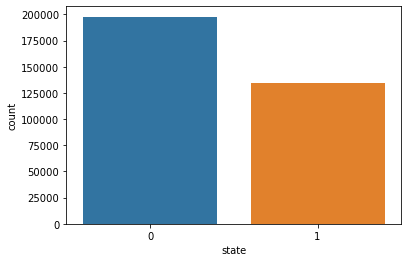

In [25]:
sns.countplot(df["state"])

#### state/currency

<AxesSubplot:xlabel='currency', ylabel='state'>

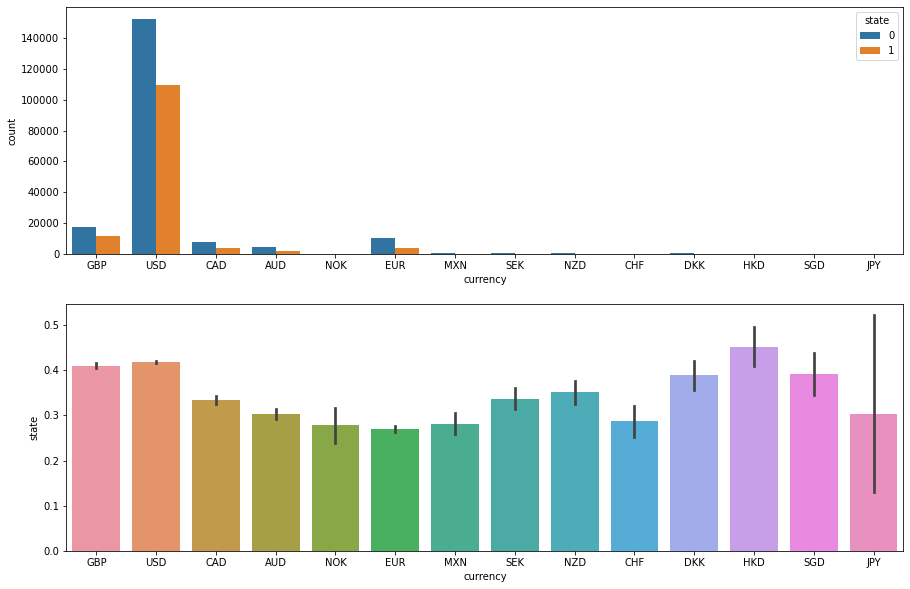

In [26]:
fig, ax = plt.subplots(2,figsize=(15,10))
sns.countplot(df["currency"],hue=df["state"],ax = ax[0])
sns.barplot(df["currency"],df["state"],ax = ax[1])

#### country/currency

<AxesSubplot:xlabel='country', ylabel='state'>

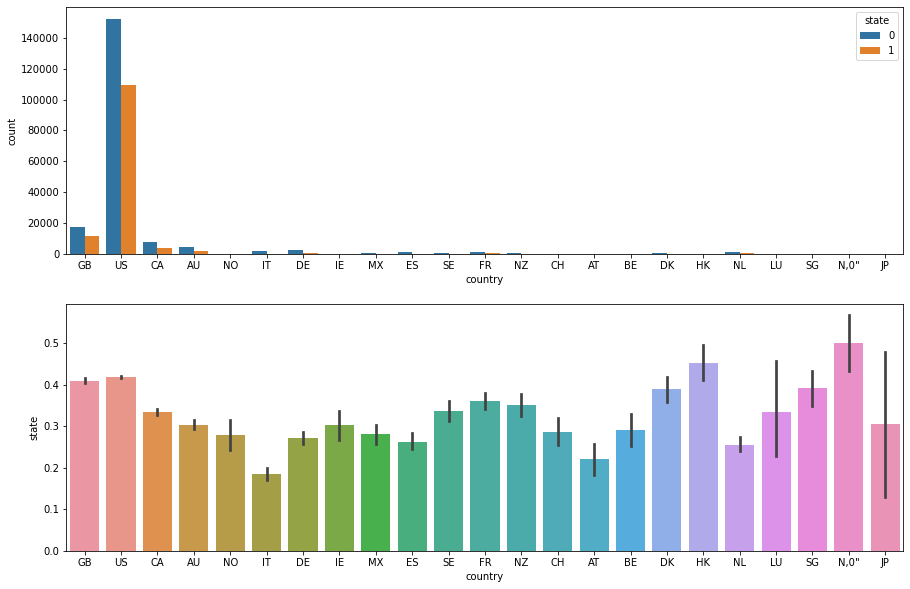

In [27]:
fig, ax = plt.subplots(2,figsize=(15,10))
sns.countplot(df["country"],hue=df["state"],ax = ax[0])
sns.barplot(df["country"],df["state"],ax = ax[1])

 #### state/main_category

<AxesSubplot:xlabel='main_category', ylabel='state'>

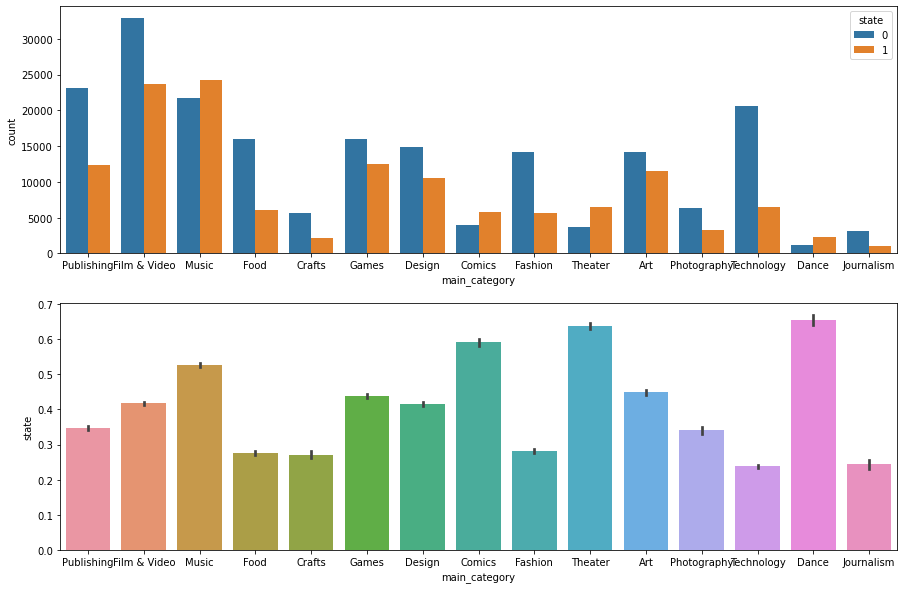

In [28]:
fig, ax = plt.subplots(2,figsize=(15,10))
sns.countplot(df["main_category"],hue=df["state"],ax = ax[0])
sns.barplot(df["main_category"],df["state"], ax = ax[1])

# 5.特微量エンジニアリング

In [29]:
df

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,58
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,59
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,44
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,29
5,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,Small Batch,Food,USD,2017-04-19,6500.0,2017-03-20 22:08:22,154.0,0,4,US,0.0,154.0,6500.00,29
378657,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,0,5,US,155.0,155.0,1500.00,26
378658,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,0,1,US,20.0,20.0,15000.00,45
378659,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,0,6,US,200.0,200.0,15000.00,30


## 5.1　ダミー変数化

In [30]:
# データフレームのコピーし、オリジナルは残す
df2 = df

for target in ["main_category","currency"]:
    df_dummy = pd.get_dummies(df2[target])
    df2 = pd.concat([df2.drop([target],axis=1),df_dummy],axis=1)

## 5.2 標準化

In [31]:
from sklearn.preprocessing import StandardScaler

# データフレームのコピーし、オリジナルは残す
df3 = df2

# 数的変数を標準化
for target in ["goal","pledged","backers","usd pledged","usd_pledged_real","usd_goal_real","period"]:
    scaler = StandardScaler()
    # DataFrameをndarrayに変換
    tmp = df3[target].to_numpy()
    # 二次元配列に変換
    tmp = tmp.reshape(len(tmp), -1)
    # 標準化した値を代入
    df3[target] = scaler.fit_transform(tmp)

In [32]:
# 学習に使う説明変数を抽出
df4 = df3[df3.columns[(df3.columns != 'category') & (df3.columns != 'launched') & (df3.columns != 'deadline') & (df3.columns != 'country')]]
df4

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period,Art,Comics,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,-0.038690,-0.104182,0,-0.120549,-0.092354,-0.102793,-0.036049,1.969990,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.012748,-0.080351,0,-0.105012,-0.091152,-0.077765,-0.010379,2.048648,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.000669,-0.102016,0,-0.117442,-0.089709,-0.100519,0.003147,0.868782,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.035111,-0.104172,0,-0.119514,-0.092342,-0.102783,-0.032924,-0.311084,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.005142,0.411363,1,0.111472,0.537281,0.438647,0.007656,0.082205,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,-0.033770,-0.102666,0,-0.116406,-0.092354,-0.101201,-0.031571,-0.311084,0,0,...,0,0,0,0,0,0,0,0,0,1
378657,-0.038242,-0.102656,0,-0.115370,-0.090491,-0.101191,-0.036080,-0.547057,0,0,...,0,0,0,0,0,0,0,0,0,1
378658,-0.026166,-0.103985,0,-0.119514,-0.092114,-0.102586,-0.023906,0.947440,0,0,...,0,0,0,0,0,0,0,0,0,1
378659,-0.026166,-0.102213,0,-0.114335,-0.089950,-0.100726,-0.023906,-0.232426,0,0,...,0,0,0,0,0,0,0,0,0,1


## 5.3 外れ値処理

In [35]:
# 数的データ抽出
num_date = df4.iloc[:,:7].drop("state", axis=1)
num_date

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
0,-0.038690,-0.104182,-0.120549,-0.092354,-0.102793,-0.036049
1,-0.012748,-0.080351,-0.105012,-0.091152,-0.077765,-0.010379
2,0.000669,-0.102016,-0.117442,-0.089709,-0.100519,0.003147
3,-0.035111,-0.104172,-0.119514,-0.092342,-0.102783,-0.032924
5,0.005142,0.411363,0.111472,0.537281,0.438647,0.007656
...,...,...,...,...,...,...
378654,-0.033770,-0.102666,-0.116406,-0.092354,-0.101201,-0.031571
378657,-0.038242,-0.102656,-0.115370,-0.090491,-0.101191,-0.036080
378658,-0.026166,-0.103985,-0.119514,-0.092114,-0.102586,-0.023906
378659,-0.026166,-0.102213,-0.114335,-0.089950,-0.100726,-0.023906


In [36]:
def detect_outliers(df, n, features):
    """
    -----------------
    df : DataFrame
    n : 閾値
    features : 対象カラム
    ------------------
    外れ値のあるindexを抽出.
    """
    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25) # 第1四分位数
        Q3 = np.percentile(df[col], 75) # 第3四分位数
        IQR = Q3 - Q1 # 四分位範囲
        
        outlier_step = 1.5 * IQR
        # 第1四分位数以下、第3四分位数以上の値を持つindex抽出
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # 配列を結合
        outlier_indices.extend(outlier_list_col)
    # 辞書型(外れ値を持つindex:出現回数)データ生成
    outlier_indices = Counter(outlier_indices)
    # n列以上外れ値を持っているレコードのindex抽出
    multiple_outliers = list(k for k , v in outlier_indices.items() if v > n)
    
    return multiple_outliers

#  外れ値を持つindexを抽出
outliers_rows =detect_outliers(df4, 2, num_date.columns)
# 外れ値を持つレコード削除
df5 = df4.drop(outliers_rows, axis = 0).reset_index(drop=True)

In [37]:
df5

,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period,Art,Comics,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,-0.038690,-0.104182,0,-0.120549,-0.092354,-0.102793,-0.036049,1.969990,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.012748,-0.080351,0,-0.105012,-0.091152,-0.077765,-0.010379,2.048648,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.000669,-0.102016,0,-0.117442,-0.089709,-0.100519,0.003147,0.868782,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.035111,-0.104172,0,-0.119514,-0.092342,-0.102783,-0.032924,-0.311084,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.038690,-0.092321,1,-0.103976,-0.077868,-0.090336,-0.036531,-1.097661,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291134,-0.033770,-0.102666,0,-0.116406,-0.092354,-0.101201,-0.031571,-0.311084,0,0,...,0,0,0,0,0,0,0,0,0,1
291135,-0.038242,-0.102656,0,-0.115370,-0.090491,-0.101191,-0.036080,-0.547057,0,0,...,0,0,0,0,0,0,0,0,0,1
291136,-0.026166,-0.103985,0,-0.119514,-0.092114,-0.102586,-0.023906,0.947440,0,0,...,0,0,0,0,0,0,0,0,0,1
291137,-0.026166,-0.102213,0,-0.114335,-0.089950,-0.100726,-0.023906,-0.232426,0,0,...,0,0,0,0,0,0,0,0,0,1


## 5.4 vif(多重共線性チェック)

In [38]:
def check_multico(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    #vifを計算する
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    #vifを計算結果を出力
    print(vif)

    #vifをグラフ化
    plt.plot(vif["VIF Factor"])

   VIF Factor          features
0   10.816579              goal
1   11.072652           pledged
2    2.310965           backers
3    5.656875       usd pledged
4   17.538796  usd_pledged_real
5   10.816019     usd_goal_real


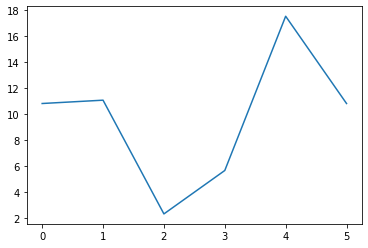

In [39]:
# 多重共線性を確認
check_multico(num_date)

   VIF Factor     features
0    1.000065         goal
1    4.208916      pledged
2    2.175364      backers
3    3.978926  usd pledged


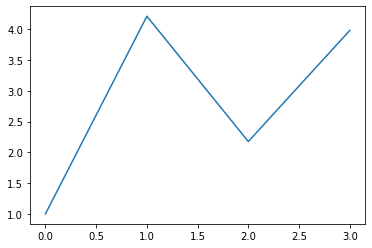

In [40]:
check_multico(num_date.drop(["usd_pledged_real","usd_goal_real"],axis=1))

In [41]:
# 多重共線性が存在するカラムを削除
df6 = df5.drop(["usd_pledged_real","usd_goal_real"],axis=1)
df6

,goal,pledged,state,backers,usd pledged,period,Art,Comics,Crafts,Dance,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,-0.038690,-0.104182,0,-0.120549,-0.092354,1.969990,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.012748,-0.080351,0,-0.105012,-0.091152,2.048648,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.000669,-0.102016,0,-0.117442,-0.089709,0.868782,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.035111,-0.104172,0,-0.119514,-0.092342,-0.311084,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-0.038690,-0.092321,1,-0.103976,-0.077868,-1.097661,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291134,-0.033770,-0.102666,0,-0.116406,-0.092354,-0.311084,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
291135,-0.038242,-0.102656,0,-0.115370,-0.090491,-0.547057,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
291136,-0.026166,-0.103985,0,-0.119514,-0.092114,0.947440,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
291137,-0.026166,-0.102213,0,-0.114335,-0.089950,-0.232426,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 5.5　数値カラムのグラフ確認

In [42]:
# 説明変数の相関係数確認
tmp = df6.drop("state", axis=1).iloc[:, :4]
tmp.corr().style.background_gradient("summer_r")

,goal,pledged,backers,usd pledged
goal,1.000000,-0.003126,-0.015860,-0.014876
pledged,-0.003126,1.000000,0.359685,0.385945
backers,-0.015860,0.359685,1.000000,0.647262
usd pledged,-0.014876,0.385945,0.647262,1.000000


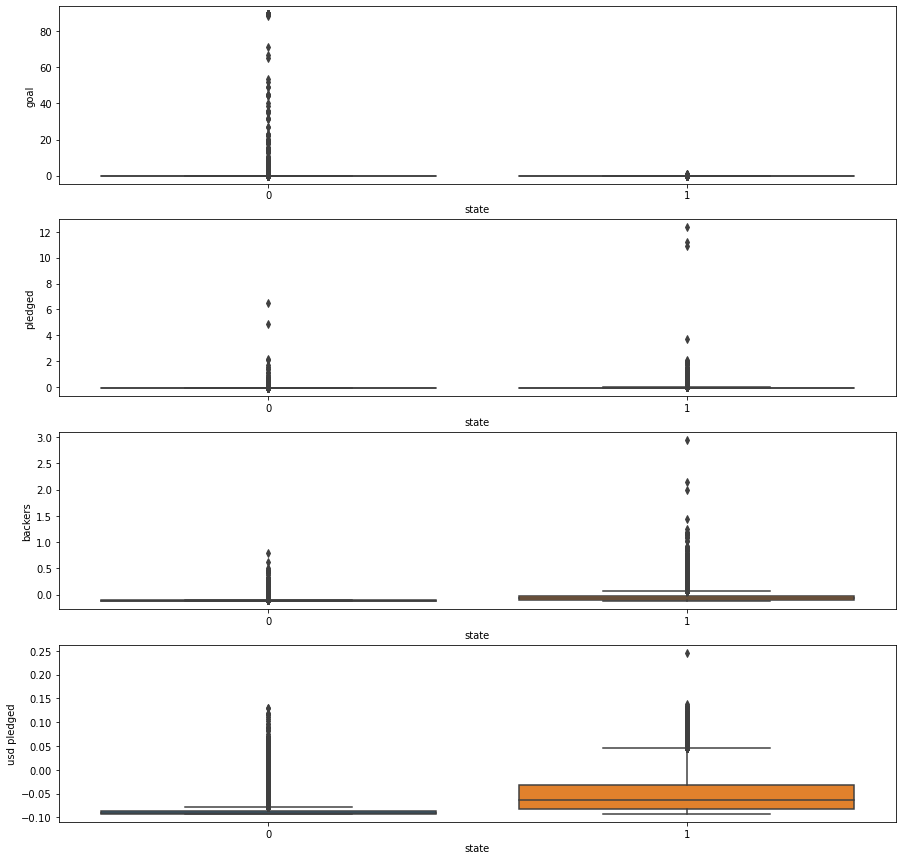

In [43]:
# 説明変数をstateごとにグラフ化
fig, ax = plt.subplots(4,1, figsize=(15,15))
sns.boxplot(df6.state,df6["goal"], ax=ax[0])
sns.boxplot(df6.state,df6["pledged"], ax=ax[1])
sns.boxplot(df6.state,df6["backers"], ax=ax[2])
sns.boxplot(df6.state,df6["usd pledged"], ax=ax[3])
plt.show()

In [44]:
tmp.describe()

,goal,pledged,backers,usd pledged
count,291139.000000,291139.000000,291139.000000,291139.000000
mean,-0.000617,-0.084437,-0.089364,-0.074384
std,1.051198,0.059062,0.052452,0.029401
min,-0.039584,-0.104182,-0.120549,-0.092354
25%,-0.038242,-0.103926,-0.118478,-0.092206
50%,-0.035111,-0.099624,-0.110191,-0.088940
75%,-0.030639,-0.079327,-0.080153,-0.069513
max,89.412654,12.357481,2.945455,0.246421


## 5.6 train/test データ分割

In [45]:
# 目的変数データ
y = df4["state"]
# 学習データ
train = df4.drop(labels=["state"],axis = 1)

In [46]:
# 学習データとテストデータに分割
train_x, val_x, train_y, val_y = train_test_split(train, y, test_size=0.2)

# 6.モデル構築

## 6.1 学習

In [47]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )
clf.fit(train_x, train_y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

w0 = -2.292, w1 = -82.730, w2 = 13.363, w3 = 20.263, w4 = 1.566, w5 = 8.647, w6 = -83.635


## 6.2 予測

In [48]:
# ラベルを予測
y_est = clf.predict(val_x)

# 確率値
y_est_proba = clf.predict_proba(val_x)

## 6.3 精度評価

In [49]:
# 対数尤度
print('対数尤度 = {:.3f}'.format(- log_loss(val_y, y_est_proba, normalize=False))) 

# 正答率
print('正答率 = {:.3f}%'.format(100 * accuracy_score(val_y, y_est)))

対数尤度 = -18263.688
正答率 = 91.005%


In [50]:
def evaluate_model_performnce(y_test, y_pred):
    """
    分類タスクの精度評価関数
    """
    cm = confusion_matrix(y_test, y_pred)
    
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax , fmt="g")
    
    # labels, title and ticks
    ax.set_xlabel("Predicted labels"); ax.set_ylabel("True labels");
    ax.set_title("Confusion Matrix");
    
    tn, fp, fn, tp = cm.ravel()
    
    # 正確性(陽性だと予測した対象の中で、実際に陽性だった割合)
    precision = tp / (tp + fp)
    # 再現性(実際に陽性だった対象に対して、陽性だと予測した割合)
    recall = tp / (tp + fn)
    # F1 調和平均 (正確性と再現率)
    f1 = 2 * (precision * recall) / (precision + recall)
    # 精度
    accuracy = ((tp + tn) / (tp + fp + tn + fn))
    print("Precision : ",precision)
    print("Recall : ",recall)
    print("F1 Score : ",f1)
    print("Validation Accuracy : ",accuracy)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy Score : ", accuracy)
    
    # 偽陽性レート、真陽性レート
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    # AUC値を算出
    auc = metrics.auc(fpr, tpr)
    print("AUC Value : ", auc)
    
    return accuracy, auc, f1

Precision :  0.9429917650055183
Recall :  0.8277134021386788
F1 Score :  0.8816000952437646
Validation Accuracy :  0.9100474862440642
Accuracy Score :  0.9100474862440642
AUC Value :  0.8968549793760034


(0.9100474862440642, 0.8968549793760034, 0.8816000952437646)

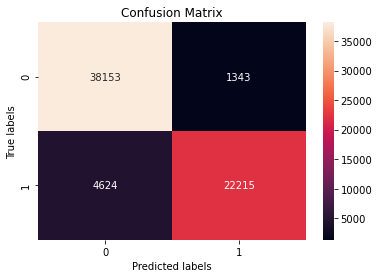

In [51]:
evaluate_model_performnce(val_y, y_est)